<a href="https://colab.research.google.com/github/jrchac/ML-Recruitment-Project/blob/main/ML_Experiments_and_Fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Experiments and Fairness Assessment

In [153]:
# importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [154]:
import warnings
warnings.filterwarnings('ignore')

In [155]:
# import csv
data = pd.read_csv('recruitmentdataset-2022-1.3.csv')
data = data[data['company']=='C']
labels = data['decision']
data = data.drop(columns = ['decision', 'Id', 'company'])

In [156]:
# normalize grades to between 0-1
grades = data['ind-university_grade']
data['ind-university_grade']= (grades-grades.min())/(grades.max()-grades.min())
data['ind-university_grade']

2000    0.344828
2001    0.448276
2002    0.448276
2003    0.275862
2004    0.827586
          ...   
2995    0.965517
2996    0.586207
2997    0.379310
2998    0.758621
2999    0.034483
Name: ind-university_grade, Length: 1000, dtype: float64

In [157]:
# function to one-hot encode categorical data that are currently strings
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [158]:
# perform one-hot encoding for these columns
features_to_encode = ['ind-degree', 'gender', 'sport', 'nationality']
for feature in features_to_encode:
    data = encode_and_bind(data, feature)

In [159]:
# column names of expanded dataframe
data.columns

Index(['age', 'ind-university_grade', 'ind-debateclub', 'ind-programming_exp',
       'ind-international_exp', 'ind-entrepeneur_exp', 'ind-languages',
       'ind-exact_study', 'ind-degree_bachelor', 'ind-degree_master',
       'ind-degree_phd', 'gender_female', 'gender_male', 'gender_other',
       'sport_Chess', 'sport_Cricket', 'sport_Football', 'sport_Golf',
       'sport_Rugby', 'sport_Running', 'sport_Swimming', 'sport_Tennis',
       'nationality_Belgian', 'nationality_Dutch', 'nationality_German'],
      dtype='object')

In [160]:
df_results = pd.DataFrame(columns = ['model', 'accuracy', 'precision', 'recall', 'f1', 'OAE_male', 'OAE_female', 'OAE_other', 'OAE_chess','OAE_cricket', 'OAE_football', 'OAE_golf', 'OAE_running', 'OAE_rugby', 'OAE_swimming', 'OAE_tennis', 'EO_male', 'EO_female', 'EO_other', 'EO_chess','EO_cricket', 'EO_football', 'EO_golf', 'EO_running', 'EO_rugby', 'EO_swimming', 'EO_tennis'])
df_results

,model,accuracy,precision,recall,f1,OAE_male,OAE_female,OAE_other,OAE_chess,OAE_cricket,...,EO_female,EO_other,EO_chess,EO_cricket,EO_football,EO_golf,EO_running,EO_rugby,EO_swimming,EO_tennis


In [161]:
m2_check = pd.DataFrame(columns = ['model', 'OAE_Dutchmale', 'OAE_Dutchfemale', 'OAE_Dutchother', 'OAE_Germanmale', 'OAE_Germanfemale', 'OAE_Germanother', 'OAE_Belgianmale', 'OAE_Belgianfemale', 'OAE_Belgianother','EO_Dutchmale', 'EO_Dutchfemale', 'EO_Dutchother', 'EO_Germanmale', 'EO_Germanfemale', 'EO_Germanother', 'EO_Belgianmale', 'EO_Belgianfemale', 'EO_Belgianother'])
m2_check

,model,OAE_Dutchmale,OAE_Dutchfemale,OAE_Dutchother,OAE_Germanmale,OAE_Germanfemale,OAE_Germanother,OAE_Belgianmale,OAE_Belgianfemale,OAE_Belgianother,EO_Dutchmale,EO_Dutchfemale,EO_Dutchother,EO_Germanmale,EO_Germanfemale,EO_Germanother,EO_Belgianmale,EO_Belgianfemale,EO_Belgianother


In [162]:
y = labels

# M1
x_svm1 = data[['age', 'ind-international_exp', 'ind-languages', 'ind-degree_bachelor']]

# M2
x_rf = data[['ind-university_grade', 'age',  'ind-languages', 'ind-international_exp', 'ind-degree_bachelor']]

# M3
x_svm2 = data[['gender_female', 'gender_male', 'gender_other', 'sport_Chess',
       'sport_Cricket', 'sport_Football', 'sport_Golf', 'sport_Rugby',
       'sport_Running', 'sport_Swimming', 'sport_Tennis',
       'nationality_Belgian', 'nationality_Dutch', 'nationality_German']]


In [163]:
# Funtion to output accuracy, precision, recall, and f1
def evaluate(predictions, test_labels):
    pred = predictions
    y_test = test_labels
    t_ac = metrics.accuracy_score(y_test, pred)
    t_prec = metrics.precision_score(y_test, pred)
    t_recal = metrics.recall_score(y_test, pred)
    t_f1 = metrics.f1_score(y_test, pred)
    return t_ac, t_prec, t_recal, t_f1

In [164]:
# For M2, function to check fairness of two combined properties (gender and nationality)
def m2_fairness(predictions, data):
    pred = predictions
    x_test = data

    y_pred_Dutch_male = pred[(x_test['gender_male']==1) & (x_test['nationality_Dutch']==1)]
    y_pred_Dutch_female = pred[(x_test['gender_female']==1) & (x_test['nationality_Dutch']==1)]
    y_pred_Dutch_other = pred[(x_test['gender_other']==1) & (x_test['nationality_Dutch']==1)]

    y_pred_Belgian_male = pred[(x_test['gender_male']==1) & (x_test['nationality_Belgian']==1)]
    y_pred_Belgian_female = pred[(x_test['gender_female']==1) & (x_test['nationality_Belgian']==1)]
    y_pred_Belgian_other = pred[(x_test['gender_other']==1) & (x_test['nationality_Belgian']==1)]

    y_pred_German_male = pred[(x_test['gender_male']==1) & (x_test['nationality_German']==1)]
    y_pred_German_female = pred[(x_test['gender_female']==1) & (x_test['nationality_German']==1)]
    y_pred_German_other = pred[(x_test['gender_other']==1) & (x_test['nationality_German']==1)]


    oae_dutch_male = metrics.accuracy_score(y_test[(x_test['gender_male']==1) & (x_test['nationality_Dutch']==1)], y_pred_Dutch_male)
    oae_dutch_female = metrics.accuracy_score(y_test[(x_test['gender_female']==1) & (x_test['nationality_Dutch']==1)], y_pred_Dutch_female)
    oae_dutch_other = metrics.accuracy_score(y_test[(x_test['gender_other']==1) & (x_test['nationality_Dutch']==1)], y_pred_Dutch_other)

    oae_german_male = metrics.accuracy_score(y_test[(x_test['gender_male']==1) & (x_test['nationality_German']==1)], y_pred_German_male)
    oae_german_female = metrics.accuracy_score(y_test[(x_test['gender_female']==1) & (x_test['nationality_German']==1)], y_pred_German_female)
    oae_german_other = metrics.accuracy_score(y_test[(x_test['gender_other']==1) & (x_test['nationality_German']==1)], y_pred_German_other)

    oae_belgian_male = metrics.accuracy_score(y_test[(x_test['gender_male']==1) & (x_test['nationality_Belgian']==1)], y_pred_Belgian_male)
    oae_belgian_female = metrics.accuracy_score(y_test[(x_test['gender_female']==1) & (x_test['nationality_Belgian']==1)], y_pred_Belgian_female)
    oae_belgian_other = metrics.accuracy_score(y_test[(x_test['gender_other']==1) & (x_test['nationality_Belgian']==1)], y_pred_Belgian_other)

    eo_dutch_male = metrics.recall_score(y_test[(x_test['gender_male']==1) & (x_test['nationality_Dutch']==1)], y_pred_Dutch_male)
    eo_dutch_female = metrics.recall_score(y_test[(x_test['gender_female']==1) & (x_test['nationality_Dutch']==1)], y_pred_Dutch_female)
    eo_dutch_other = metrics.recall_score(y_test[(x_test['gender_other']==1) & (x_test['nationality_Dutch']==1)], y_pred_Dutch_other)

    eo_german_male = metrics.recall_score(y_test[(x_test['gender_male']==1) & (x_test['nationality_German']==1)], y_pred_German_male)
    eo_german_female = metrics.recall_score(y_test[(x_test['gender_female']==1) & (x_test['nationality_German']==1)], y_pred_German_female)
    eo_german_other = metrics.recall_score(y_test[(x_test['gender_other']==1) & (x_test['nationality_German']==1)], y_pred_German_other)

    eo_belgian_male = metrics.recall_score(y_test[(x_test['gender_male']==1) & (x_test['nationality_Belgian']==1)], y_pred_Belgian_male)
    eo_belgian_female = metrics.recall_score(y_test[(x_test['gender_female']==1) & (x_test['nationality_Belgian']==1)], y_pred_Belgian_female)
    eo_belgian_other = metrics.recall_score(y_test[(x_test['gender_other']==1) & (x_test['nationality_Belgian']==1)], y_pred_Belgian_other)

    return oae_dutch_male, oae_dutch_female, oae_dutch_other, oae_german_male, oae_german_female, oae_german_other, oae_belgian_male, oae_belgian_female, oae_belgian_other, eo_dutch_male, eo_dutch_female, eo_dutch_other, eo_german_male, eo_german_female, eo_german_other, eo_belgian_male, eo_belgian_female, eo_belgian_other


In [165]:
# Function to check gender and sport OAE
def overall_accuracy_equality(predictions, data):
    pred = predictions
    x_test = data

    # predictions for a given gender
    y_pred_male = pred[x_test['gender_male']==1]
    y_pred_female = pred[x_test['gender_female']==1]
    y_pred_other = pred[x_test['gender_other']==1]

    # predictions specific for a given sport
    y_pred_chess = pred[x_test['sport_Chess']==1]
    y_pred_cricket = pred[x_test['sport_Cricket']==1]
    y_pred_football = pred[x_test['sport_Football']==1]
    y_pred_golf = pred[x_test['sport_Golf']==1]
    y_pred_running = pred[x_test['sport_Running']==1]
    y_pred_rugby = pred[x_test['sport_Rugby']==1]
    y_pred_swimming = pred[x_test['sport_Swimming']==1]
    y_pred_tennis = pred[x_test['sport_Tennis']==1]


    # OAE scores for each gender
    oae_male = metrics.accuracy_score(y_test[x_test['gender_male']==1], y_pred_male)
    oae_female = metrics.accuracy_score(y_test[x_test['gender_female']==1], y_pred_female)
    oae_other = metrics.accuracy_score(y_test[x_test['gender_other']==1], y_pred_other)

    # OAE scores for each sport
    oae_chess = metrics.accuracy_score(y_test[x_test['sport_Chess']==1], y_pred_chess)
    oae_cricket = metrics.accuracy_score(y_test[x_test['sport_Cricket']==1], y_pred_cricket)
    oae_football = metrics.accuracy_score(y_test[x_test['sport_Football']==1], y_pred_football)
    oae_golf = metrics.accuracy_score(y_test[x_test['sport_Golf']==1], y_pred_golf)
    oae_running = metrics.accuracy_score(y_test[x_test['sport_Running']==1], y_pred_running)
    oae_rugby = metrics.accuracy_score(y_test[x_test['sport_Rugby']==1], y_pred_rugby)
    oae_swimming = metrics.accuracy_score(y_test[x_test['sport_Swimming']==1], y_pred_swimming)
    oae_tennis = metrics.accuracy_score(y_test[x_test['sport_Tennis']==1], y_pred_tennis)


    # predictions specific for a given nationality
    # uncomment below to add in nationality fairness check
    #y_pred_dutch = pred[x_test['nationality_Dutch']==1]
    #y_pred_german = pred[x_test['nationality_German']==1]
    #y_pred_belgian = pred[x_test['nationality_Belgian']==1]

    # OAE for each nationality
    #oae_dutch = metrics.accuracy_score(y_test[x_test['nationality_Dutch']==1], y_pred_dutch)
    #oae_german = metrics.accuracy_score(y_test[x_test['nationality_German']==1], y_pred_german)
    #oae_belgian = metrics.accuracy_score(y_test[x_test['nationality_Belgian']==1], y_pred_belgian)


    return oae_male, oae_female, oae_other, oae_chess, oae_cricket, oae_football, oae_golf, oae_running, oae_rugby, oae_swimming, oae_tennis

    # if want to add in nationality uncomment below instead
    #return oae_male, oae_female, oae_other, oae_chess, oae_cricket, oae_football, oae_golf, oae_running, oae_rugby, oae_swimming, oae_tennis, oae_dutch, oae_german, oae_belgian

In [166]:
# Function to check gender and sport EO
def equal_opportunity(predictions, data):
    pred = predictions
    x_test = data

    # predictions for a given gender
    y_pred_male = pred[x_test['gender_male']==1]
    y_pred_female = pred[x_test['gender_female']==1]
    y_pred_other = pred[x_test['gender_other']==1]

    # predictions specific for a given sport
    y_pred_chess = pred[x_test['sport_Chess']==1]
    y_pred_cricket = pred[x_test['sport_Cricket']==1]
    y_pred_football = pred[x_test['sport_Football']==1]
    y_pred_golf = pred[x_test['sport_Golf']==1]
    y_pred_running = pred[x_test['sport_Running']==1]
    y_pred_rugby = pred[x_test['sport_Rugby']==1]
    y_pred_swimming = pred[x_test['sport_Swimming']==1]
    y_pred_tennis = pred[x_test['sport_Tennis']==1]


    # EO scores for each gender
    eo_male = metrics.recall_score(y_test[x_test['gender_male']==1], y_pred_male)
    eo_female = metrics.recall_score(y_test[x_test['gender_female']==1], y_pred_female)
    eo_other = metrics.recall_score(y_test[x_test['gender_other']==1], y_pred_other)

    # EO scores for each sport
    eo_chess = metrics.recall_score(y_test[x_test['sport_Chess']==1], y_pred_chess)
    eo_cricket = metrics.recall_score(y_test[x_test['sport_Cricket']==1], y_pred_cricket)
    eo_football = metrics.recall_score(y_test[x_test['sport_Football']==1], y_pred_football)
    eo_golf = metrics.recall_score(y_test[x_test['sport_Golf']==1], y_pred_golf)
    eo_running = metrics.recall_score(y_test[x_test['sport_Running']==1], y_pred_running)
    eo_rugby = metrics.recall_score(y_test[x_test['sport_Rugby']==1], y_pred_rugby)
    eo_swimming = metrics.recall_score(y_test[x_test['sport_Swimming']==1], y_pred_swimming)
    eo_tennis = metrics.recall_score(y_test[x_test['sport_Tennis']==1], y_pred_tennis)


    # predictions specific for a given nationality
    # uncomment below to add in nationality fairness check
    #y_pred_dutch = pred[x_test['nationality_Dutch']==1]
    #y_pred_german = pred[x_test['nationality_German']==1]
    #y_pred_belgian = pred[x_test['nationality_Belgian']==1]

    # OAE for each nationality
    #eo_dutch = metrics.recall_score(y_test[x_test['nationality_Dutch']==1], y_pred_dutch)
    #eo_german = metrics.recall_score(y_test[x_test['nationality_German']==1], y_pred_german)
    #eo_belgian = metrics.recall_score(y_test[x_test['nationality_Belgian']==1], y_pred_belgian)

    return eo_male, eo_female, eo_other, eo_chess, eo_cricket, eo_football, eo_golf, eo_running, eo_rugby, eo_swimming, eo_tennis

    # if want to add in nationality uncomment below instead
    #return eo_male, eo_female, eo_other, eo_chess, eo_cricket, eo_football, eo_golf, eo_running, eo_rugby, eo_swimming, eo_tennis, eo_dutch, eo_german, eo_belgian



# Running each model 10 times
in order to obtain more comprehensive performance

In [167]:
# M1
# SVM 1

# Initialize an empty list to store dictionaries

results_list = []

for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2, train_size=0.8, random_state=i)
    x_train_features, x_test_features, y_train_features, y_test_features = train_test_split(x_svm1, y, test_size=0.2, train_size=0.8, random_state=i)
    model = SVC(C=1000000, gamma='scale', kernel="rbf")
    model = model.fit(x_train_features, y_train_features)
    pred = model.predict(x_test_features)
    t_ac, t_prec, t_recal, t_f1 = evaluate(pred, y_test_features)

    eo_male, eo_female, eo_other, eo_chess, eo_cricket, eo_football, eo_golf, eo_running, eo_rugby, eo_swimming, eo_tennis = equal_opportunity(pred, x_test)
    oae_male, oae_female, oae_other, oae_chess, oae_cricket, oae_football, oae_golf, oae_running, oae_rugby, oae_swimming, oae_tennis = overall_accuracy_equality(pred, x_test)

    # This dictionary will help us saving the results of
    result_dict = {'model': 'SVM1',
                   'accuracy': t_ac, 'precision': t_prec, 'recall': t_recal, 'f1': t_f1,
                   'OAE_male': eo_male, 'OAE_female': eo_female, 'OAE_other': eo_other,
                   'OAE_chess': eo_chess, 'OAE_cricket': eo_cricket, 'OAE_football': eo_football,
                   'OAE_golf': eo_golf, 'OAE_running': eo_running, 'OAE_rugby': eo_rugby,
                   'OAE_swimming': eo_swimming, 'OAE_tennis': eo_tennis, 'EO_male': eo_male,
                   'EO_female': eo_female, 'EO_other': eo_other, 'EO_chess': eo_chess,
                   'EO_cricket': eo_cricket, 'EO_football': eo_football, 'EO_golf': eo_golf,
                   'EO_running': eo_running, 'EO_rugby': eo_rugby, 'EO_swimming': eo_swimming,
                   'EO_tennis': eo_tennis}

    # Append the dictionary to the list
    results_list.append(result_dict)

#svm1_results = pd.DataFrame(results_list)
df_results = pd.DataFrame(results_list)
print('svm1 done')


svm1 done


In [168]:
# M2
# RF

# Initialize an empty list to store dictionaries

results_list = []

for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2, train_size=0.8, random_state=i)
    x_train_features, x_test_features, y_train_features, y_test_features = train_test_split(x_svm1, y, test_size=0.2, train_size=0.8, random_state=i)
    model = RandomForestClassifier(n_estimators = 200, max_depth = 7)
    model = model.fit(x_train_features, y_train_features)
    pred = model.predict(x_test_features)

    t_ac, t_prec, t_recal, t_f1 = evaluate(pred, y_test_features)

    eo_male, eo_female, eo_other, eo_chess, eo_cricket, eo_football, eo_golf, eo_running, eo_rugby, eo_swimming, eo_tennis = equal_opportunity(pred, x_test)
    oae_male, oae_female, oae_other, oae_chess, oae_cricket, oae_football, oae_golf, oae_running, oae_rugby, oae_swimming, oae_tennis = overall_accuracy_equality(pred, x_test)

    # This dictionary will help us saving the results of
    result_dict = {'model': 'RF',
                   'accuracy': t_ac, 'precision': t_prec, 'recall': t_recal, 'f1': t_f1,
                   'OAE_male': eo_male, 'OAE_female': eo_female, 'OAE_other': eo_other,
                   'OAE_chess': eo_chess, 'OAE_cricket': eo_cricket, 'OAE_football': eo_football,
                   'OAE_golf': eo_golf, 'OAE_running': eo_running, 'OAE_rugby': eo_rugby,
                   'OAE_swimming': eo_swimming, 'OAE_tennis': eo_tennis, 'EO_male': eo_male,
                   'EO_female': eo_female, 'EO_other': eo_other, 'EO_chess': eo_chess,
                   'EO_cricket': eo_cricket, 'EO_football': eo_football, 'EO_golf': eo_golf,
                   'EO_running': eo_running, 'EO_rugby': eo_rugby, 'EO_swimming': eo_swimming,
                   'EO_tennis': eo_tennis}

    # Append the dictionary to the list
    results_list.append(result_dict)

df_results = pd.concat([df_results, pd.DataFrame(results_list)])
print('RF done')


RF done


In [169]:
# M3
# sv2

# Initialize an empty list to store dictionaries
results_list = []

for i in range(5):
    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2, train_size=0.8, random_state=i)
    x_train_features, x_test_features, y_train_features, y_test_features = train_test_split(x_svm1, y, test_size=0.2, train_size=0.8, random_state=i)
    model = SVC(C=1000, gamma='auto', kernel="poly")
    model = model.fit(x_train_features, y_train_features)
    pred = model.predict(x_test_features)

    t_ac, t_prec, t_recal, t_f1 = evaluate(pred, y_test_features)

    eo_male, eo_female, eo_other, eo_chess, eo_cricket, eo_football, eo_golf, eo_running, eo_rugby, eo_swimming, eo_tennis = equal_opportunity(pred, x_test)
    oae_male, oae_female, oae_other, oae_chess, oae_cricket, oae_football, oae_golf, oae_running, oae_rugby, oae_swimming, oae_tennis = overall_accuracy_equality(pred, x_test)

    # This dictionary will help us saving the results of
    result_dict = {'model': 'SVM2',
                   'accuracy': t_ac, 'precision': t_prec, 'recall': t_recal, 'f1': t_f1,
                   'OAE_male': eo_male, 'OAE_female': eo_female, 'OAE_other': eo_other,
                   'OAE_chess': eo_chess, 'OAE_cricket': eo_cricket, 'OAE_football': eo_football,
                   'OAE_golf': eo_golf, 'OAE_running': eo_running, 'OAE_rugby': eo_rugby,
                   'OAE_swimming': eo_swimming, 'OAE_tennis': eo_tennis, 'EO_male': eo_male,
                   'EO_female': eo_female, 'EO_other': eo_other, 'EO_chess': eo_chess,
                   'EO_cricket': eo_cricket, 'EO_football': eo_football, 'EO_golf': eo_golf,
                   'EO_running': eo_running, 'EO_rugby': eo_rugby, 'EO_swimming': eo_swimming,
                   'EO_tennis': eo_tennis}

    # Append the dictionary to the list
    results_list.append(result_dict)

df_results = pd.concat([df_results, pd.DataFrame(results_list)])
print('svm2 done')


svm2 done


In [170]:
df_results

,model,accuracy,precision,recall,f1,OAE_male,OAE_female,OAE_other,OAE_chess,OAE_cricket,...,EO_female,EO_other,EO_chess,EO_cricket,EO_football,EO_golf,EO_running,EO_rugby,EO_swimming,EO_tennis
0,SVM1,0.825,0.710526,0.529412,0.606742,0.466667,0.600000,1.0,0.500000,0.833333,...,0.600000,1.0,0.500000,0.833333,0.454545,0.800000,0.20,0.750000,0.444444,0.000000
1,SVM1,0.865,0.820513,0.615385,0.703297,0.636364,0.611111,0.0,0.500000,0.600000,...,0.611111,0.0,0.500000,0.600000,0.500000,0.833333,0.75,0.666667,0.375000,1.000000
2,SVM1,0.845,0.763158,0.568627,0.651685,0.517241,0.619048,1.0,0.400000,0.750000,...,0.619048,1.0,0.400000,0.750000,0.642857,0.500000,0.50,0.545455,0.400000,1.000000
3,SVM1,0.865,0.875000,0.614035,0.721649,0.605263,0.705882,0.0,0.750000,1.000000,...,0.705882,0.0,0.750000,1.000000,0.428571,0.750000,0.00,0.714286,0.400000,0.750000
4,SVM1,0.835,0.724138,0.456522,0.560000,0.500000,0.416667,0.0,0.333333,0.500000,...,0.416667,0.0,0.333333,0.500000,0.444444,0.600000,0.00,0.636364,0.125000,1.000000
5,SVM1,0.855,0.750000,0.488372,0.591549,0.476190,0.550000,0.0,0.500000,0.666667,...,0.550000,0.0,0.500000,0.666667,0.333333,0.500000,0.00,0.625000,0.500000,0.333333
6,SVM1,0.840,0.781250,0.500000,0.609756,0.555556,0.428571,0.5,0.666667,0.600000,...,0.428571,0.5,0.666667,0.600000,0.625000,0.000000,0.00,0.476190,0.250000,0.500000
7,SVM1,0.845,0.741935,0.500000,0.597403,0.541667,0.476190,0.0,0.428571,0.500000,...,0.476190,0.0,0.428571,0.500000,0.500000,0.750000,0.00,0.454545,0.428571,1.000000
8,SVM1,0.825,0.800000,0.500000,0.615385,0.472222,0.526316,1.0,0.500000,0.500000,...,0.526316,1.0,0.500000,0.500000,0.250000,0.857143,0.50,0.526316,0.285714,1.000000
9,SVM1,0.850,0.757576,0.531915,0.625000,0.517241,0.562500,0.5,1.000000,0.900000,...,0.562500,0.5,1.000000,0.900000,0.333333,1.000000,0.00,0.454545,0.200000,0.333333


In [171]:
#m2_check.to_excel("m2_fairness.xlsx")

In [172]:
#df_results.to_excel("results.xlsx")

In [173]:
rf = df_results[df_results['model']=='RF']
rf_mean = rf['f1'].mean()
print(f'rf mean f1 score: {rf_mean}')

svm1 = df_results[df_results['model']=='SVM1']
svm1_mean = svm1['f1'].mean()
print(f'SVM1 mean f1 score: {svm1_mean}')

svm2 = df_results[df_results['model']=='SVM2']
svm2_mean = svm2['f1'].mean()
print(f'SVM2 mean f1 score: {svm2_mean}')

rf mean f1 score: 0.6289193841502303
SVM1 mean f1 score: 0.6282465760247756
SVM2 mean f1 score: 0.6032816982214573


In [174]:
#recall formula is EO and accuracy formula is OAE

# Compare Gender Fairness for 3 Models

In [175]:
res_svm1 = df_results[df_results['model']=='SVM1']
res_rf = df_results[df_results['model']=='RF']
res_svm2 = df_results[df_results['model']=='SVM2']

## Gender OAE

In [176]:
models = ["M1","M2","M3"]

gender_OAE = pd.DataFrame(data=models, columns = ["Model"])
gender_OAE["OAE_male"] = [res_svm1["OAE_male"].mean(), res_rf["OAE_male"].mean(),res_svm2["OAE_male"].mean()]
gender_OAE["OAE_female"] = [res_svm1["OAE_female"].mean(), res_rf["OAE_female"].mean(),res_svm2["OAE_female"].mean()]
gender_OAE["OAE_other"] = [res_svm1["OAE_other"].mean(), res_rf["OAE_other"].mean(),res_svm2["OAE_other"].mean()]
gender_OAE

,Model,OAE_male,OAE_female,OAE_other
0,M1,0.528841,0.549629,0.40
1,M2,0.581068,0.540973,0.25
2,M3,0.505062,0.502428,0.20


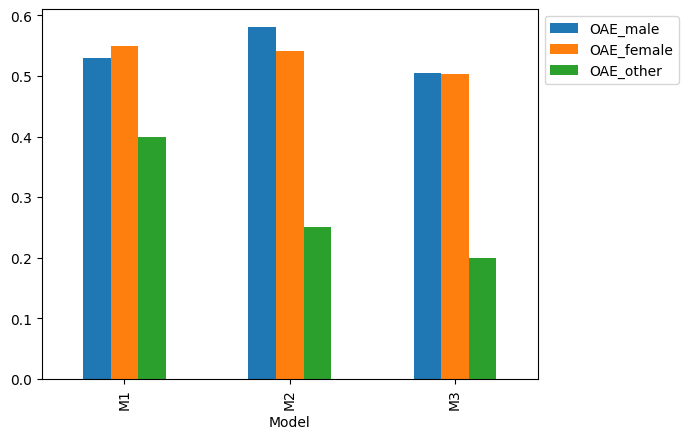

In [177]:
gender_OAE.plot.bar(x="Model")
plt.legend(bbox_to_anchor= (1, 1))

## Gender EO

In [178]:
gender_EO = pd.DataFrame(data=models, columns = ["Model"])
gender_EO["EO_male"] = [res_svm1["EO_male"].mean(), res_rf["EO_male"].mean(),res_svm2["EO_male"].mean()]
gender_EO["EO_female"] = [res_svm1["EO_female"].mean(), res_rf["EO_female"].mean(),res_svm2["EO_female"].mean()]
gender_EO["EO_other"] = [res_svm1["EO_other"].mean(), res_rf["EO_other"].mean(),res_svm2["EO_other"].mean()]
gender_EO

,Model,EO_male,EO_female,EO_other
0,M1,0.528841,0.549629,0.40
1,M2,0.581068,0.540973,0.25
2,M3,0.505062,0.502428,0.20


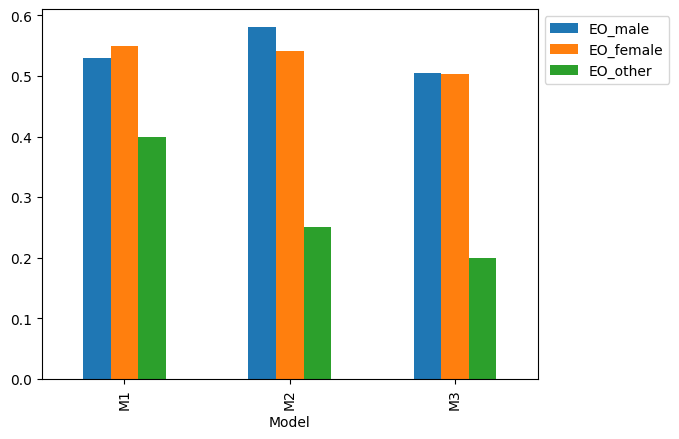

In [179]:
gender_EO.plot.bar(x="Model")
plt.legend(bbox_to_anchor= (1, 1))

# Compare Sport Fairness for 3 Models

## Sport OAE

In [180]:
sport_OAE = pd.DataFrame(data=models, columns = ["Model"])
sport_OAE["OAE_chess"] = [res_svm1["OAE_chess"].mean(), res_rf["OAE_chess"].mean(),res_svm2["OAE_chess"].mean()]
sport_OAE["OAE_cricket"] = [res_svm1["OAE_cricket"].mean(), res_rf["OAE_cricket"].mean(),res_svm2["OAE_cricket"].mean()]
sport_OAE["OAE_football"] = [res_svm1["OAE_football"].mean(), res_rf["OAE_football"].mean(),res_svm2["OAE_football"].mean()]
sport_OAE["OAE_golf"] = [res_svm1["OAE_golf"].mean(), res_rf["OAE_golf"].mean(),res_svm2["OAE_golf"].mean()]
sport_OAE["OAE_running"] = [res_svm1["OAE_running"].mean(), res_rf["OAE_running"].mean(),res_svm2["OAE_running"].mean()]
sport_OAE["OAE_rugby"] = [res_svm1["OAE_rugby"].mean(), res_rf["OAE_rugby"].mean(),res_svm2["OAE_rugby"].mean()]
sport_OAE["OAE_swimming"] = [res_svm1["OAE_swimming"].mean(), res_rf["OAE_swimming"].mean(),res_svm2["OAE_swimming"].mean()]
sport_OAE["OAE_tennis"] = [res_svm1["OAE_tennis"].mean(), res_rf["OAE_tennis"].mean(),res_svm2["OAE_tennis"].mean()]
sport_OAE

,Model,OAE_chess,OAE_cricket,OAE_football,OAE_golf,OAE_running,OAE_rugby,OAE_swimming,OAE_tennis
0,M1,0.557857,0.685000,0.451209,0.659048,0.195,0.584937,0.340873,0.691667
1,M2,0.522143,0.846667,0.441486,0.696548,0.195,0.618825,0.305476,0.725000
2,M3,0.396667,0.630000,0.510750,0.491667,0.280,0.610173,0.264444,0.583333


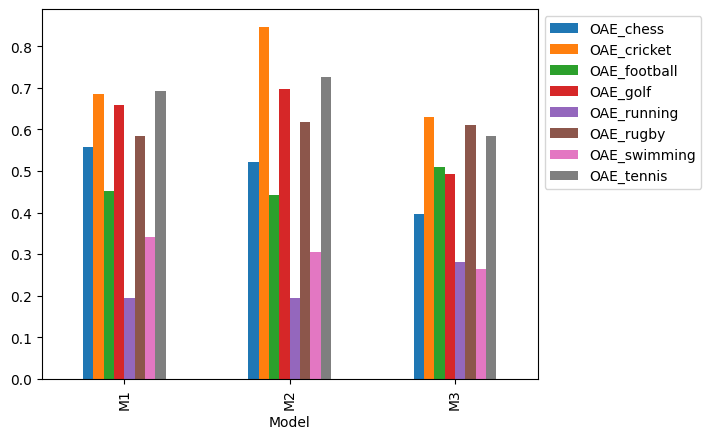

In [181]:
sport_OAE.plot.bar(x="Model")
plt.legend(bbox_to_anchor= (1, 1))

## Sport EO

In [182]:
sport_EO = pd.DataFrame(data=models, columns = ["Model"])
sport_EO["EO_chess"] = [res_svm1["EO_chess"].mean(), res_rf["EO_chess"].mean(),res_svm2["EO_chess"].mean()]
sport_EO["EO_cricket"] = [res_svm1["EO_cricket"].mean(), res_rf["EO_cricket"].mean(),res_svm2["EO_cricket"].mean()]
sport_EO["EO_football"] = [res_svm1["EO_football"].mean(), res_rf["EO_football"].mean(),res_svm2["EO_football"].mean()]
sport_EO["EO_golf"] = [res_svm1["EO_golf"].mean(), res_rf["EO_golf"].mean(),res_svm2["EO_golf"].mean()]
sport_EO["EO_running"] = [res_svm1["EO_running"].mean(), res_rf["EO_running"].mean(),res_svm2["EO_running"].mean()]
sport_EO["EO_rugby"] = [res_svm1["EO_rugby"].mean(), res_rf["EO_rugby"].mean(),res_svm2["EO_rugby"].mean()]
sport_EO["EO_swimming"] = [res_svm1["EO_swimming"].mean(), res_rf["EO_swimming"].mean(),res_svm2["EO_swimming"].mean()]
sport_EO["EO_tennis"] = [res_svm1["EO_tennis"].mean(), res_rf["EO_tennis"].mean(),res_svm2["EO_tennis"].mean()]
#sport_EO.style.background_gradient()
sport_EO

,Model,EO_chess,EO_cricket,EO_football,EO_golf,EO_running,EO_rugby,EO_swimming,EO_tennis
0,M1,0.557857,0.685000,0.451209,0.659048,0.195,0.584937,0.340873,0.691667
1,M2,0.522143,0.846667,0.441486,0.696548,0.195,0.618825,0.305476,0.725000
2,M3,0.396667,0.630000,0.510750,0.491667,0.280,0.610173,0.264444,0.583333


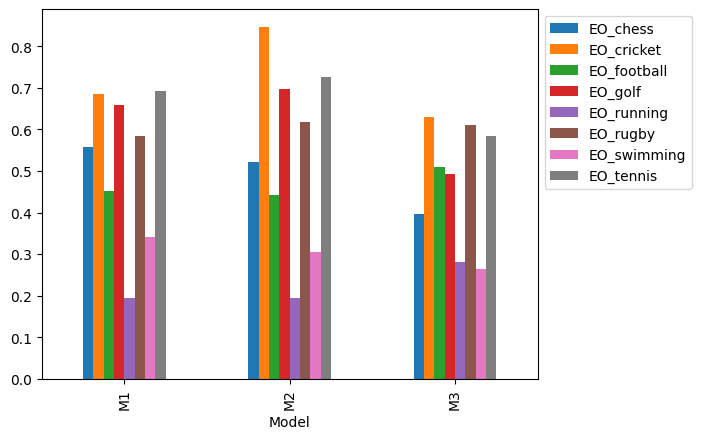

In [183]:
sport_EO.plot.bar(x="Model")
#plt.gca().set_ylim([0, 1.1])
#plt.legend(ncol = 2, columnspacing = 10)
plt.legend(bbox_to_anchor= (1, 1))

# Compare Performance for 3 Models

In [184]:
performance_agg = pd.DataFrame(data=models, columns = ["Model"])
performance_agg["accuracy"] = [res_svm1["accuracy"].mean(), res_rf["accuracy"].mean(),res_svm2["accuracy"].mean()]
performance_agg["precision"] = [res_svm1["precision"].mean(), res_rf["precision"].mean(),res_svm2["precision"].mean()]
performance_agg["recall"] = [res_svm1["recall"].mean(), res_rf["recall"].mean(),res_svm2["recall"].mean()]
performance_agg["f1"] = [res_svm1["f1"].mean(), res_rf["f1"].mean(),res_svm2["f1"].mean()]
performance_agg

,Model,accuracy,precision,recall,f1
0,M1,0.8450,0.772410,0.530427,0.628247
1,M2,0.8385,0.733459,0.554519,0.628919
2,M3,0.8350,0.789600,0.496510,0.603282


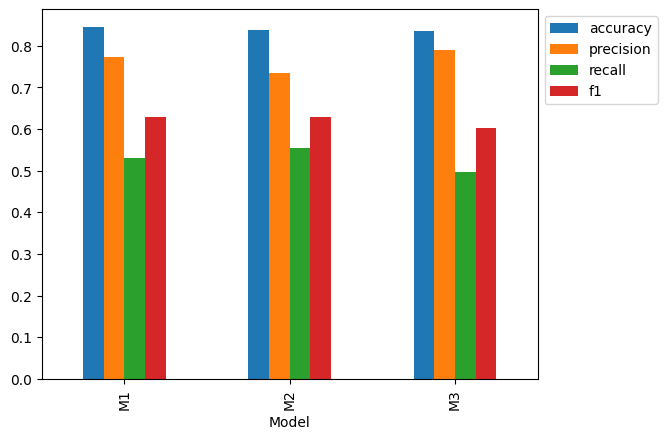

In [185]:
performance_agg.plot.bar(x="Model")
plt.legend(bbox_to_anchor= (1, 1))

# (if nationality fairness check needed run below)

In [186]:
#nationality_OAE = pd.DataFrame(data=models, columns = ["Model"])
#nationality_OAE["OAE_dutch"] = [res_svm1["OAE_dutch"], res_rf["OAE_dutch"],res_svm2["OAE_dutch"]]
#nationality_OAE["OAE_german"] = [res_svm1["OAE_german"], res_rf["OAE_german"],res_svm2["OAE_german"]]
#nationality_OAE["OAE_belgian"] = [res_svm1["OAE_belgian"], res_rf["OAE_belgian"],res_svm2["OAE_belgian"]]
#nationality_OAE

In [187]:
#nationality_OAE.plot.bar(x="Model")
#plt.legend(bbox_to_anchor= (1, 1))

In [188]:
#nationality_EO = pd.DataFrame(data=models, columns = ["Model"])
#nationality_EO["EO_dutch"] = [res_svm1["EO_dutch"], res_rf["EO_dutch"],res_svm2["EO_dutch"]]
#nationality_EO["EO_german"] = [res_svm1["EO_german"], res_rf["EO_german"],res_svm2["EO_german"]]
#nationality_EO["EO_belgian"] = [res_svm1["EO_belgian"], res_rf["EO_belgian"],res_svm2["EO_belgian"]]
#nationality_EO

In [189]:
#nationality_EO.plot.bar(x="Model")
#plt.legend(bbox_to_anchor= (1, 1))